<a href="https://colab.research.google.com/github/IgorekFromRU/HyperParametrOptimization/blob/master/ML_7_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B1%D0%B8%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D1%82%D0%B2%D0%B5%D1%82%D0%B0_(HW_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML-7. Прогнозирование биологического ответа (HW-3)

![Biomolecules](https://media.geeksforgeeks.org/wp-content/uploads/20220719115043/C581.png)

## Задача

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу
(столбцы D1-D1776).

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
#импорт библиотек
from time import time
import numpy as np
import pandas as pd #для анализа и предобработки данных

from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier #деревья решений
from sklearn.ensemble import RandomForestClassifier #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [8]:
RANDOMSTATE = 42
MAX_ITER = 50
name_lr = 'LogisticRegression'
name_rf = 'RandomForestClassifier'

# создадим таблицу для обобщения итогов
score_table = pd.DataFrame(columns=['name_model','optimization', 'score_f1', 'best_params'])

---

## 1. Знакомство с данными и их исследование

Данные представлены в формате CSV.  Каждая строка представляет молекулу.

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

In [3]:

#ЕСЛИ РАБОТАЕМ В IDE
#data = pd.read_csv('data\_train_sem09__1_.zip')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
from google.colab import drive
drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
data = pd.read_csv('./drive/MyDrive/DS/data/_train_sem09__1_.zip')
data.head(2)

Mounted at /content/drive


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0


In [4]:
print('Размер таблицы: ', data.shape)
print('Наличие пропусков: ', data.isnull().sum().sum())

Размер таблицы:  (3751, 1777)
Наличие пропусков:  0


Смотрим на сбалансированность классов:

In [5]:
#sns.countplot(data=data, x='Activity')
data['Activity'].value_counts(normalize=True)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

Создаем матрицу наблюдений $X$ и вектор ответов $y$

Разделим выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

In [9]:
X, y = data.drop(['Activity'], axis=1), data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = RANDOMSTATE, test_size = 0.2)

---
## 2. Базовая оптимизация

In [10]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

# ---------------------
def show_info(df, name_model, hpo, score, best_params=None):
    df.loc[ len(df.index )] = [name_model, hpo, score, best_params]
    print(f'Классификатор: {name_model}. Оптимизация гиперпараметров: {hpo}.')
    print('Метрика f1_score на тестовом наборе: ', score)
    print("Наилучшие значения гиперпараметров: ", best_params)


Параметры по умолчанию :
- class sklearn.ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_leaf=1)
- class sklearn.linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs )

### **LogisticRegression**

In [11]:
#Создаем объект класса логистическая регрессия и обучаем
log_reg = LogisticRegression(random_state=RANDOMSTATE, max_iter=MAX_ITER).fit(X_train, y_train)

score = metrics.f1_score(y_test, log_reg.predict(X_test)).round(4)
show_info(score_table, name_lr, 'default', score,
                best_params="(penalty='l2', C=1.0, solver='lbfgs )")

Классификатор: LogisticRegression. Оптимизация гиперпараметров: default.
Метрика f1_score на тестовом наборе:  0.7767
Наилучшие значения гиперпараметров:  (penalty='l2', C=1.0, solver='lbfgs )


**RandomForestClassifier**

In [13]:
#Создаем объект класса Случайный лес и обучаем
rf = RandomForestClassifier(random_state=RANDOMSTATE).fit(X_train, y_train)

score = metrics.f1_score(y_test, rf.predict(X_test)).round(4)
show_info(score_table, name_rf, 'default', score,
          best_params="(n_estimators=100, criterion='gini', max_depth=None, min_samples_leaf=1)")

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: default.
Метрика f1_score на тестовом наборе:  0.8048
Наилучшие значения гиперпараметров:  (n_estimators=100, criterion='gini', max_depth=None, min_samples_leaf=1)


## 3. GridSearchCV


###  **LogisticRegression**
#### Алгоритм оптимизации для LogisticRegression зависит от выбранного типа штрафа:

- 'newton-cg' - ['l2', 'none']
- 'lbfgs' - ['l2', 'none']
- 'liblinear' - ['l1', 'l2']
- 'sag' - ['l2', 'none']
- 'saga' - [elasticnet', 'l1', 'l2', 'none']

In [14]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации

              # {'penalty': ['l1', 'l2'] ,
              # 'solver': ['liblinear', 'saga'],
              #  'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=RANDOMSTATE,max_iter=MAX_ITER)
    , param_grid=param_grid
    # For int/None inputs, if the estimator is a classifier and y is
    # either binary or multiclass, StratifiedKFold is used. In all
    # other cases, KFold is used.
    , cv=5
    , scoring='f1'
    , n_jobs = -1
    )

start=time()
grid_search_lr.fit(X_train, y_train)
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search_lr.cv_results_["params"]))
)
report(grid_search_lr.cv_results_)

# Оба варианта вычисляют F1-меру на тестовом наборе данных
# с использованием модели, обученной с лучшими гиперпараметрами.
# Разница заключается в том, как это делается - через метод .score
# или через явное предсказание и metrics.f1_score.
#print(f"f1 на тестовом наборе: {grid_search_lr.score(X_test, y_test):.4f}")
best_score = metrics.f1_score(y_test, grid_search_lr.predict(X_test)).round(4)
show_info(score_table, name_lr, 'GridSearchCV', best_score, grid_search_lr.best_params_)

GridSearchCV took 230.86 seconds for 28 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.788 (std: 0.019)
Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}

Model with rank: 2
Mean validation score: 0.788 (std: 0.018)
Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.786 (std: 0.016)
Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}

Классификатор: LogisticRegression. Оптимизация гиперпараметров: GridSearchCV.
Метрика f1_score на тестовом наборе:  0.781
Наилучшие значения гиперпараметров:  {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}


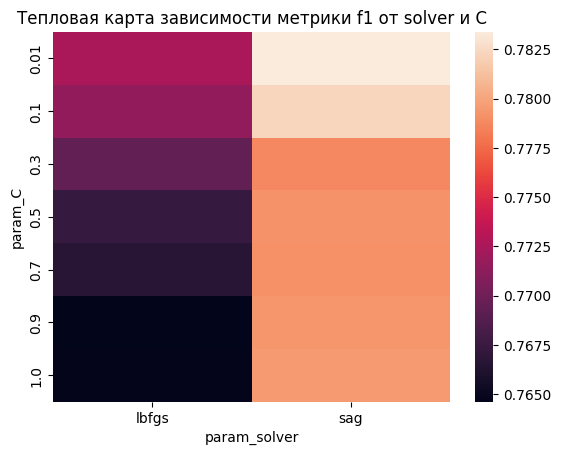

In [15]:
# отрисуем, как менялась метрика f1 при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_lr.cv_results_)
                        , values='mean_test_score', index='param_C'
                        # , columns='param_penalty'
                        , columns='param_solver'
                      )
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики f1 от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

### **RandomForestClassifier**

In [18]:
param_grid = {'n_estimators': list(range(80, 200, 30))
              , 'min_samples_leaf': list(np.linspace(2, 10, 2, dtype=int)) #[5]
              , 'max_depth': list(np.linspace(10, 40, 5, dtype=int))
              }

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOMSTATE)
    , param_grid=param_grid
    , cv=5
    , scoring= 'f1'
    , n_jobs = -1
)

start=time()
grid_search_rf.fit(X_train, y_train)
elapsed_time = time() - start
print(f'GridSearchCV took {elapsed_time:2f} seconds for {len(grid_search_rf.cv_results_["params"])} candidate parameter settings.')
report(grid_search_rf.cv_results_)

best_score = metrics.f1_score(y_test, grid_search_rf.predict(X_test)).round(4)
show_info(score_table, name_rf, 'GridSearchCV', best_score, grid_search_rf.best_params_)

GridSearchCV took 308.650510 seconds for 40 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.819 (std: 0.020)
Parameters: {'max_depth': 17, 'min_samples_leaf': 2, 'n_estimators': 110}

Model with rank: 2
Mean validation score: 0.818 (std: 0.019)
Parameters: {'max_depth': 17, 'min_samples_leaf': 2, 'n_estimators': 170}

Model with rank: 3
Mean validation score: 0.818 (std: 0.023)
Parameters: {'max_depth': 32, 'min_samples_leaf': 2, 'n_estimators': 170}

Model with rank: 3
Mean validation score: 0.818 (std: 0.023)
Parameters: {'max_depth': 40, 'min_samples_leaf': 2, 'n_estimators': 170}

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: GridSearchCV.
Метрика f1_score на тестовом наборе:  0.7864
Наилучшие значения гиперпараметров:  {'max_depth': 17, 'min_samples_leaf': 2, 'n_estimators': 110}


### **HalvingGridSearchCV**

In [21]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {'n_estimators': list(range(80, 200, 30))
              , 'min_samples_leaf': list(np.linspace(2, 10, 2, dtype=int)) #[5]
              , 'max_depth': list(np.linspace(10, 40, 5, dtype=int))
              }

grid_search_halving_rf = HalvingGridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOMSTATE)
    , param_grid=param_grid
    , cv=5
    , scoring= 'f1'
    , factor=2
    , n_jobs = -1
)

tic=time()
grid_search_halving_rf.fit(X_train, y_train)
elapsed_time = time() - tic
print(f'HalvingGridSearchCV took {elapsed_time:2f} seconds for {len(grid_search_halving_rf.cv_results_["params"])} candidate parameter settings.')
report(grid_search_halving_rf.cv_results_)

best_score = metrics.f1_score(y_test, grid_search_halving_rf.predict(X_test)).round(4)
show_info(score_table, name_rf, 'HalvingGridSearchCV', best_score, grid_search_halving_rf.best_params_)

GridSearchCV took 165.876045 seconds for 80 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.816 (std: 0.021)
Parameters: {'max_depth': 40, 'min_samples_leaf': 2, 'n_estimators': 140}

Model with rank: 2
Mean validation score: 0.812 (std: 0.023)
Parameters: {'max_depth': 17, 'min_samples_leaf': 2, 'n_estimators': 140}

Model with rank: 3
Mean validation score: 0.787 (std: 0.013)
Parameters: {'max_depth': 40, 'min_samples_leaf': 2, 'n_estimators': 140}

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: HalvingGridSearchCV.
Метрика f1_score на тестовом наборе:  0.7971
Наилучшие значения гиперпараметров:  {'max_depth': 40, 'min_samples_leaf': 2, 'n_estimators': 140}


---
## 4. RandomizedSearchCV

### **LogisticRegression**

In [22]:
param_distributions = {'penalty': ['l2', 'none'] ,
                        'solver': ['lbfgs', 'sag'],
                        'C': list(np.linspace(0.01, 1, 10, dtype=float))
                      }

random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=RANDOMSTATE, max_iter=MAX_ITER)
    , param_distributions=param_distributions
    , cv=5
    , scoring='f1'
    , n_iter = MAX_ITER #10
    , n_jobs = -1
)
start = time()
random_search_lr.fit(X_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), MAX_ITER)
)
report(random_search_lr.cv_results_)

best_score = metrics.f1_score(y_test, random_search_lr.predict(X_test)).round(4)
show_info(score_table, name_lr, 'RandomizedSearchCV', best_score, random_search_lr.best_params_)

RandomizedSearchCV took 325.75 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.788 (std: 0.019)
Parameters: {'solver': 'sag', 'penalty': 'l2', 'C': 0.01}

Model with rank: 2
Mean validation score: 0.788 (std: 0.018)
Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}

Model with rank: 3
Mean validation score: 0.785 (std: 0.016)
Parameters: {'solver': 'sag', 'penalty': 'l2', 'C': 0.12}

Классификатор: LogisticRegression. Оптимизация гиперпараметров: RandomizedSearchCV.
Метрика f1_score на тестовом наборе:  0.781
Наилучшие значения гиперпараметров:  {'solver': 'sag', 'penalty': 'l2', 'C': 0.01}


### **RandomForestClassifier**

In [23]:
param_distributions = {'n_estimators': list(range(80, 200, 1))
                       , 'min_samples_leaf': list(np.linspace(2, 10, 2, dtype=int)) #[5]
                       , 'max_depth': list(np.linspace(10, 40, 1, dtype=int))
                      }

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOMSTATE)
    , param_distributions=param_distributions
    , cv=5
    , scoring='f1'
    , n_iter = MAX_ITER #10
    , n_jobs = -1
)

tic=time()
random_search_rf.fit(X_train, y_train)
print(f'RandomizedSearchCV took {(time() - tic):2f} seconds for {MAX_ITER} candidates parameter settings.')
report(random_search_rf.cv_results_)

score = metrics.f1_score(y_test, random_search_rf.predict(X_test)).round(4)
show_info(score_table, name_rf, 'RandomizedSearchCV', score, random_search_rf.best_params_)

RandomizedSearchCV took 373.403196 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.812 (std: 0.025)
Parameters: {'n_estimators': 155, 'min_samples_leaf': 2, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.812 (std: 0.020)
Parameters: {'n_estimators': 95, 'min_samples_leaf': 2, 'max_depth': 10}

Model with rank: 3
Mean validation score: 0.811 (std: 0.026)
Parameters: {'n_estimators': 163, 'min_samples_leaf': 2, 'max_depth': 10}

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: RandomizedSearchCV.
Метрика f1_score на тестовом наборе:  0.7898
Наилучшие значения гиперпараметров:  {'n_estimators': 155, 'min_samples_leaf': 2, 'max_depth': 10}


---
## 5. Hyperopt

In [28]:
#делаем импорт и выведем версию библиотеки

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : ", hyperopt.__version__)

Версия Hyperopt :  0.2.7


### **LogisticRegression**

In [29]:
def hyperopt_lr(params):
  estimator = LogisticRegression(
            penalty=params['penalty']
          , solver=params['solver']
          , C=params['C']
          , random_state=RANDOMSTATE
          , max_iter=MAX_ITER
  )

  # Выполняем кросс-валидацию и используем F1-меру как метрику для оптимизации
  mean_f1 = cross_val_score(estimator, X_train, y_train, cv=5, scoring="f1", n_jobs = -1).mean()

  # Возвращаем минус среднюю F1-меру, так как Hyperopt максимизирует функцию, а мы хотим минимизировать метрику
  return {'loss': -mean_f1, 'status': STATUS_OK}
  # score = metrics.f1_score(y_train, estimator.predict(X_train))
  # return -1.0 * score


In [30]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

space = {
          'penalty': hp.choice('penalty', ['l2', 'none']),
          'solver': hp.choice('solver', ['lbfgs', 'sag']),
          'C': hp.uniform('C', 0.01, 1.0)
}

best = fmin(fn=hyperopt_lr, space=space, algo=tpe.suggest, max_evals=MAX_ITER, trials=trials,
                rstate=np.random.default_rng(RANDOMSTATE))
#print("Лучшие параметры:", best)

100%|██████████| 50/50 [05:23<00:00,  6.46s/trial, best loss: -0.7951361235981371]
CPU times: user 5.38 s, sys: 2.11 s, total: 7.5 s
Wall time: 5min 23s


In [31]:

#print("Лучшие параметры:", best)
best_params = hyperopt.space_eval(space, best)
#print("Лучшие параметры (полные):", best_params)
best_estimator = LogisticRegression(**best_params, random_state=RANDOMSTATE, max_iter=MAX_ITER)
best_estimator.fit(X_train, y_train)
best_f1_score = metrics.f1_score(y_test, best_estimator.predict(X_test)).round(4)
# print("Лучшая F1-мера:", best_f1_score)

show_info(score_table, name_lr, 'HyperOpt (CV)', best_f1_score, best_params)

Классификатор: LogisticRegression. Оптимизация гиперпараметров: HyperOpt (CV).
Метрика f1_score на тестовом наборе:  0.7796
Наилучшие значения гиперпараметров:  {'C': 0.017331323696411022, 'penalty': 'l2', 'solver': 'lbfgs'}


### **RandomForestClassifier**

In [32]:
def hyperopt_rf(params):
    estimator = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_leaf=int(params['min_samples_leaf']),
        random_state=RANDOMSTATE
    )

    # Выполняем кросс-валидацию и используем F1-меру как метрику для оптимизации
    mean_f1 = cross_val_score(estimator, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

    # Возвращаем минус среднюю F1-меру, так как Hyperopt максимизирует функцию, а мы хотим минимизировать метрику
    return {'loss': -mean_f1, 'status': STATUS_OK}

    # score = metrics.f1_score(y_train, estimator.predict(X_train))
    # return -1.0 * score


In [54]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

space={'n_estimators': hp.quniform('n_estimators', 80, 200, 1)
        , 'max_depth' : hp.quniform('max_depth', 1, 40, 1)
        , 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
      }

best=fmin(fn=hyperopt_rf, space=space, algo=tpe.suggest, max_evals=30, trials=trials,
              rstate=np.random.default_rng(RANDOMSTATE)
)

100%|██████████| 30/30 [04:08<00:00,  8.29s/trial, best loss: -0.8201412242765471]
CPU times: user 3.87 s, sys: 1.4 s, total: 5.28 s
Wall time: 4min 8s


In [55]:
# рассчитаем метрику f1 для тестовой выборки
#print("Лучшие параметры:", best)
best_params = hyperopt.space_eval(space, best)
#print("Лучшие параметры (полные):", best_params)
best_params = {key: int(value) for key, value in best_params.items()}
best_estimator = RandomForestClassifier(**best_params, random_state=RANDOMSTATE)
best_estimator.fit(X_train, y_train)
best_f1_score = metrics.f1_score(y_test, best_estimator.predict(X_test)).round(4)
#print("Лучшая F1-мера:", best_f1_score)

show_info(score_table, name_rf, 'HyperOpt (CV)', best_f1_score, best_params)

Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: HyperOpt (CV).
Метрика f1_score на тестовом наборе:  0.8093
Наилучшие значения гиперпараметров:  {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 119}


In [35]:
# score_table = score_table.drop(score_table.index[-1])
# score_table


---
## 6. Optuna

In [ ]:
!pip install optuna

In [37]:
import optuna

print("Версия Optuna: ", optuna.__version__)

Версия Optuna:  3.3.0


In [49]:
###########   LogisticRegression   ################
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  params = {'penalty': trial.suggest_categorical('penalty', ['l2', 'none'])
            , 'solver': trial.suggest_categorical('solver', ['lbfgs', 'sag'])
            , 'C': trial.suggest_float('C', 0.01, 1.0, log=True)
          }

  # создаем модель, обучаем на кросс-валидации и получаем оценку f1 на обучающем наборе
  estimator = LogisticRegression(**params, random_state=RANDOMSTATE, max_iter=MAX_ITER)
  mean_f1 = cross_val_score(estimator, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  return mean_f1

###########   RandomForestClassifier   ################

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  params = { 'n_estimators': trial.suggest_int('n_estimators', 80, 200, 1)
            , 'max_depth': trial.suggest_int('max_depth', 1, 40, 1)
            , 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8, 1)
  }

  # создаем модель, обучаем на кросс-валидации и получаем оценку f1 на обучающем наборе
  estimator = RandomForestClassifier(**params, random_state=RANDOMSTATE)
  mean_f1 = cross_val_score(estimator, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  return mean_f1



### **LogisticRegression**

In [39]:
# cоздаем объект исследования
study_lr = optuna.create_study(study_name=name_lr, direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study_lr.optimize(optuna_lr, n_trials=MAX_ITER)

[I 2023-09-12 16:19:12,178] A new study created in memory with name: LogisticRegression
[I 2023-09-12 16:19:29,678] Trial 0 finished with value: 0.7802467940718147 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.8643753407586453}. Best is trial 0 with value: 0.7802467940718147.
[I 2023-09-12 16:19:32,115] Trial 1 finished with value: 0.7574579769635668 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.02511495097069333}. Best is trial 0 with value: 0.7802467940718147.
[I 2023-09-12 16:19:34,525] Trial 2 finished with value: 0.7938445971695497 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.020526399684727154}. Best is trial 2 with value: 0.7938445971695497.
[I 2023-09-12 16:19:49,849] Trial 3 finished with value: 0.7789014212164245 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.84064538109832}. Best is trial 2 with value: 0.7938445971695497.
[I 2023-09-12 16:20:05,163] Trial 4 finished with value: 0.7789014212164245 and parameters: {'penal

CPU times: user 5.14 s, sys: 2.21 s, total: 7.35 s
Wall time: 4min 30s


In [40]:
# рассчитаем метрику f1 для тестовой выборки
best_estimator = LogisticRegression(**study_lr.best_params, random_state=RANDOMSTATE, max_iter=MAX_ITER)
best_estimator.fit(X_train, y_train)

best_f1_score = metrics.f1_score(y_test, best_estimator.predict(X_test)).round(4)
show_info(score_table, name_lr, 'Optuna (CV)', best_f1_score, study_lr.best_params)


Классификатор: LogisticRegression. Оптимизация гиперпараметров: Optuna (CV).
Метрика f1_score на тестовом наборе:  0.7829
Наилучшие значения гиперпараметров:  {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.019353232119299988}


### **RandomForestClassifier**

In [50]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name=name_rf, direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study_rf.optimize(optuna_rf, n_trials=20)


[I 2023-09-12 17:03:42,680] A new study created in memory with name: RandomForestClassifier
[I 2023-09-12 17:03:49,350] Trial 0 finished with value: 0.8118997887471323 and parameters: {'n_estimators': 96, 'max_depth': 27, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8118997887471323.
[I 2023-09-12 17:04:00,818] Trial 1 finished with value: 0.8098249843483002 and parameters: {'n_estimators': 167, 'max_depth': 38, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8118997887471323.
[I 2023-09-12 17:04:04,288] Trial 2 finished with value: 0.763979208343512 and parameters: {'n_estimators': 131, 'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8118997887471323.
[I 2023-09-12 17:04:08,178] Trial 3 finished with value: 0.7218443508746546 and parameters: {'n_estimators': 146, 'max_depth': 1, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8118997887471323.
[I 2023-09-12 17:04:17,022] Trial 4 finished with value: 0.8092211183863112 and parameters: {'n_esti

CPU times: user 3.14 s, sys: 1 s, total: 4.14 s
Wall time: 3min 28s


In [51]:
# рассчитаем метрику f1 для тестовой выборки
best_estimator = RandomForestClassifier(**study_rf.best_params, random_state=RANDOMSTATE).fit(X_train, y_train)

best_f1_score = metrics.f1_score(y_test, best_estimator.predict(X_test)).round(4)
show_info(score_table, name_rf, 'Optuna (CV)', best_f1_score, study_rf.best_params)


Классификатор: RandomForestClassifier. Оптимизация гиперпараметров: Optuna (CV).
Метрика f1_score на тестовом наборе:  0.8068
Наилучшие значения гиперпараметров:  {'n_estimators': 188, 'max_depth': 35, 'min_samples_leaf': 1}


---
## Вывод

In [52]:
pd.set_option('display.max_colwidth', None)
score_table.sort_values(by=['name_model','score_f1'])


,name_model,optimization,score_f1,best_params
0,LogisticRegression,default,0.7767,"(penalty='l2', C=1.0, solver='lbfgs )"
7,LogisticRegression,HyperOpt (CV),0.7796,"{'C': 0.017331323696411022, 'penalty': 'l2', 'solver': 'lbfgs'}"
2,LogisticRegression,GridSearchCV,0.7810,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}"
5,LogisticRegression,RandomizedSearchCV,0.7810,"{'solver': 'sag', 'penalty': 'l2', 'C': 0.01}"
9,LogisticRegression,Optuna (CV),0.7829,"{'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.019353232119299988}"
3,RandomForestClassifier,GridSearchCV,0.7864,"{'max_depth': 17, 'min_samples_leaf': 2, 'n_estimators': 110}"
6,RandomForestClassifier,RandomizedSearchCV,0.7898,"{'n_estimators': 155, 'min_samples_leaf': 2, 'max_depth': 10}"
4,RandomForestClassifier,HalvingGridSearchCV,0.7971,"{'max_depth': 40, 'min_samples_leaf': 2, 'n_estimators': 140}"
8,RandomForestClassifier,HyperOpt (CV),0.8024,"{'max_depth': 29, 'min_samples_leaf': 2, 'n_estimators': 126}"
10,RandomForestClassifier,Optuna (CV),0.8043,"{'n_estimators': 161, 'max_depth': 39, 'min_samples_leaf': 2}"


In [87]:
# compression_opts = dict(method='zip', archive_name='hpo.csv')
# path_file = './drive/MyDrive/DS/data/hpo.zip'
# score_table.to_csv(path_file, index=False, compression=compression_opts)
# score_table = pd.read_csv(path_file)

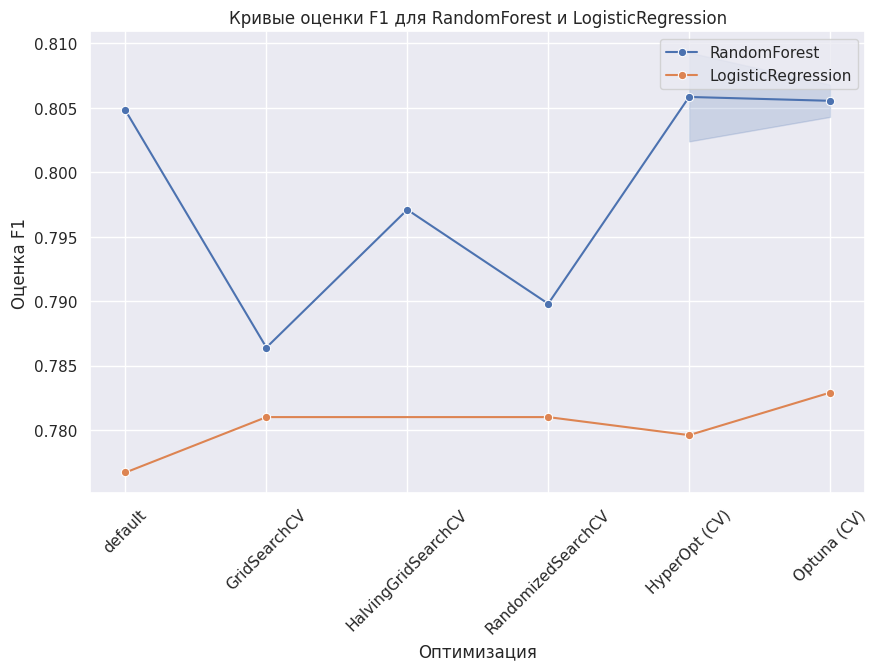

In [56]:
rf_data = score_table[score_table['name_model'] == 'RandomForestClassifier']
lr_data = score_table[score_table['name_model'] == 'LogisticRegression']

# График для RandomForest
plt.figure(figsize=(10, 6))
sns.lineplot(data=rf_data, x='optimization', y='score_f1', label='RandomForest', marker='o')

# График для LogisticRegression
sns.lineplot(data=lr_data, x='optimization', y='score_f1', label='LogisticRegression', marker='o')

# Внешний вид графика
plt.title('Кривые оценки F1 для RandomForest и LogisticRegression')
plt.xlabel('Оптимизация')
plt.ylabel('Оценка F1')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.show()



#### Вывод : Классификатор RandomForestClassifier выдает лучшие характеристики по предсказанию по сравнению с логистической регрессией. Разброс лучших параметров возможно либо из-за ограничения MAX_ITER, либо расширить поиск диапазона гиперпараметров